# Image loading:

In [1]:
from skimage import data, color, transform, io, filters, morphology, exposure
import cv2
from PIL import Image

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!mkdir -p ../data/out

In [3]:
PATH = "../data/"

In [4]:
!ls ../data

IMG_0018.jpg  IMG_0028.jpg  out  task_2_unsharp_blur.jpg


Read the image:

In [5]:
im = Image.open(PATH + "IMG_0018.jpg").convert("LA")
im.save(PATH + "out/greyscale.png")
im = cv2.imread(PATH + "out/greyscale.png")

Normalize and resize the image 

In [6]:
im_norm = cv2.normalize(
    im, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
)
i = cv2.resize(im_norm, (500, 500), interpolation=cv2.INTER_AREA)
print(im_norm.size)

45023328


Now you can show it:

float32
0.992157
0.06829668


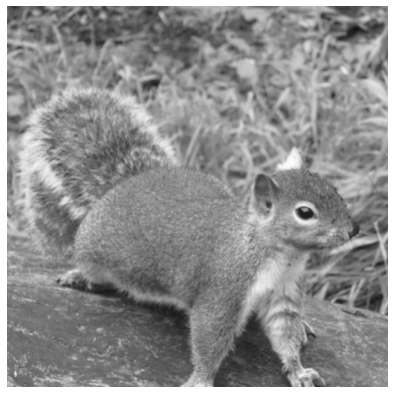

In [7]:
figure(figsize(7, 7))
imshow(i)
axis("off")
print(i.dtype)
print(i.max())
print(i.min())

# Change image contrast and brightness:

You can use point operations to change the image contrast and brightness:

In [8]:
def point_operation(point, contrast, brightness):
    point_out = point * contrast + brightness
    return clip(point_out, 0, 1)


point_operation = vectorize(point_operation)

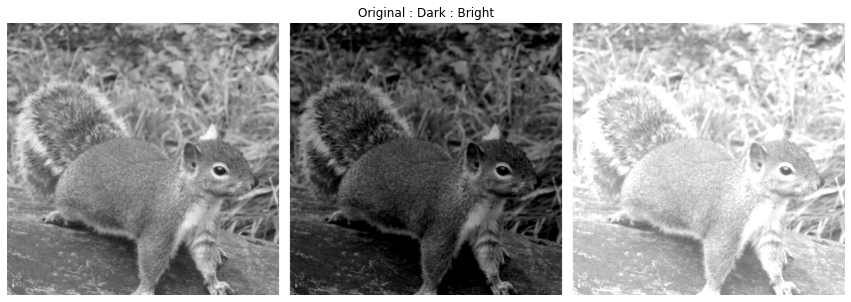

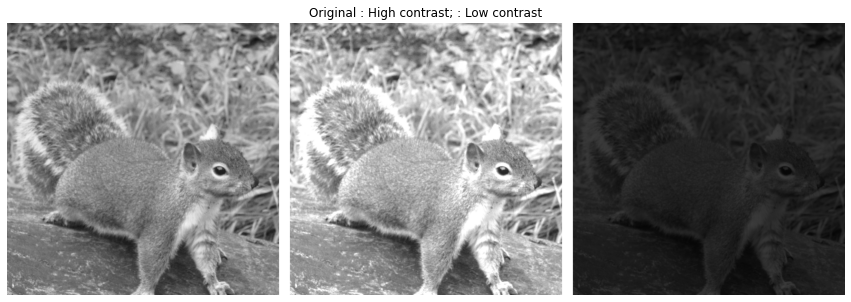

In [9]:
i_dark = point_operation(i, 1, -0.3)
i_bright = point_operation(i, 1, 0.3)
vBorder = np.ones(shape=(500, 20, 3))
brightness = np.hstack((i, vBorder, i_dark, vBorder, i_bright))

figure(figsize=(16, 5))
imshow(brightness)
title("Original : Dark : Bright")
axis("off")


i_high_contrast = point_operation(i, 1.3, 0)
i_low_contrast = point_operation(i, 0.25, 0)
contrast = np.hstack((i, vBorder, i_high_contrast, vBorder, i_low_contrast))

figure(figsize=(16, 5))
imshow(contrast)
title("Original : High contrast; : Low contrast")
axis("off")

pass

A much faster way to do it, is by using operations on numpy arrays:

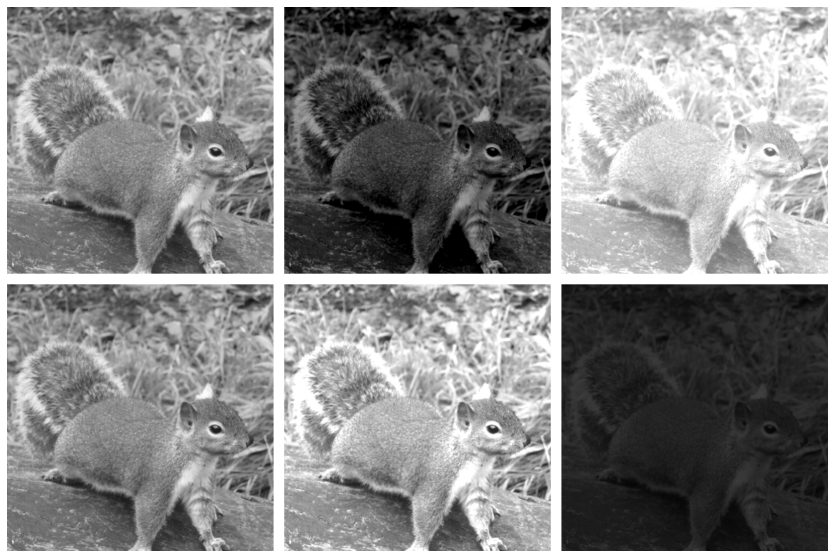

In [10]:
i = np.array(i)

# add or substract a number from array to change the brightness
i_dark = clip(i - 0.3, 0, 1)
i_bright = clip(i + 0.3, 0, 1)

# multiply array by a number to change it's contrast
i_high_contrast = clip(i * 1.3, 0, 1)
i_low_contrast = clip(i * 0.25, 0, 1)

brightness = np.hstack((i, vBorder, i_dark, vBorder, i_bright))
contrast = np.hstack((i, vBorder, i_high_contrast, vBorder, i_low_contrast))
hBorder = np.ones(shape=(20, len(brightness[0]), 3))
both = np.vstack((brightness, hBorder, contrast))

figure(figsize=(16, 10))
imshow(both)
axis("off")

pass

You can plot the performed operation to see if there is a potential information loss:

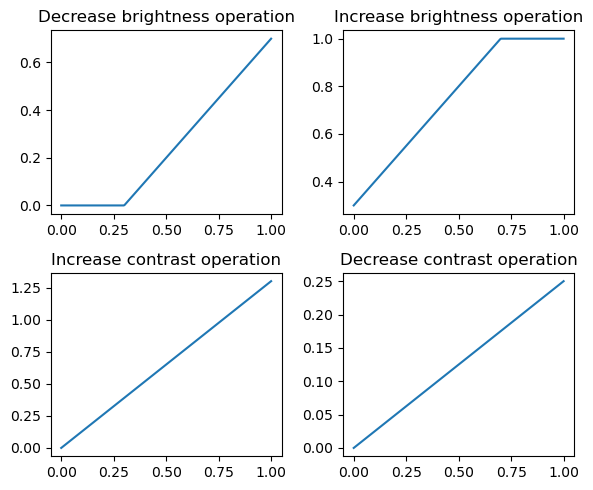

In [11]:
x = np.linspace(0,1,256)

fig, ax = subplots(nrows=2,ncols=2,figsize=(6,5), dpi=100)

ax[0][0].plot(x,clip(x - 0.3, 0, 1))
ax[0][0].set_title('Decrease brightness operation')

ax[0][1].plot(x, clip(x + 0.3, 0, 1))
ax[0][1].set_title('Increase brightness operation')

ax[1][0].plot(x, x * 1.3)
ax[1][0].set_title('Increase contrast operation')

ax[1][1].plot(x, x * 0.25)
ax[1][1].set_title('Decrease contrast operation')
fig.tight_layout()

Alternative way, is to normalize the image again:

(-0.5, 499.5, 499.5, -0.5)

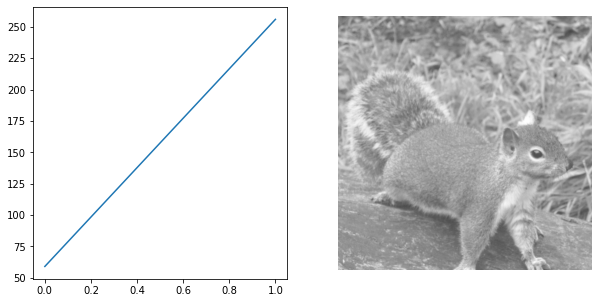

In [12]:
fig, ax = subplots(ncols=2, nrows=1, figsize=(10, 5))
x = np.linspace(0, 1, 256)
y = x + 0.3
y *= 256 / y.max()
ax[0].plot(x, y)

i_bright = i + 0.3
i_bright *= 1 / i_bright.max()
ax[1].imshow(i_bright)
ax[1].axis("off")

Show a hitogram for the image:

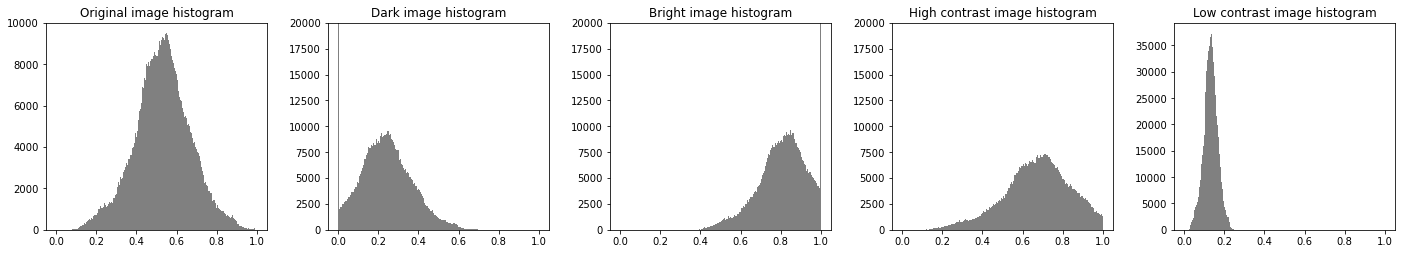

In [13]:
i_dark = clip(i - 0.3, 0, 1)
i_bright = clip(i + 0.3, 0, 1)
i_high_contrast = i * 1.3
i_low_contrast = i * 0.25

fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.tight_layout(pad=3)
ax[0].hist(i.flatten(), 256, [0, 1], color="gray")
ax[0].set_title("Original image histogram")
ax[1].hist(i_dark.flatten(), 256, [0, 1], color="gray")
ax[1].set_title("Dark image histogram")
ax[1].set_ylim(0, 20000)
ax[2].hist(i_bright.flatten(), 256, [0, 1], color="gray")
ax[2].set_title("Bright image histogram")
ax[2].set_ylim(0, 20000)
ax[3].hist(i_high_contrast.flatten(), 256, [0, 1], color="gray")
ax[3].set_title("High contrast image histogram")
ax[3].set_ylim(0, 20000)
ax[4].hist(i_low_contrast.flatten(), 256, [0, 1], color="gray")
ax[4].set_title("Low contrast image histogram")
show()

# Histogram equalization:

In [14]:
from skimage import exposure
import numpy as np


def histogram_equalize(img):
    img_cdf, bin_centers = exposure.cumulative_distribution(img)
    return np.interp(img, bin_centers, img_cdf)

In [15]:
i_eq = histogram_equalize(i)
i_dark_eq = histogram_equalize(i_dark)
i_bright_eq = histogram_equalize(i_bright)
i_high_eq = histogram_equalize(i_high_contrast)
i_low_eq = histogram_equalize(i_low_contrast)

/opt/conda/lib/python3.9/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


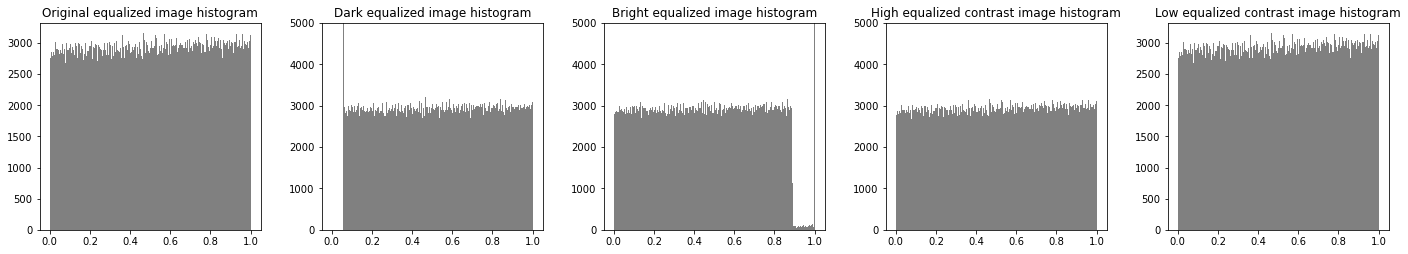

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.tight_layout(pad=3)
ax[0].hist(i_eq.flatten(), 256, [0, 1], color="gray")
ax[0].set_title("Original equalized image histogram")
ax[1].hist(i_dark_eq.flatten(), 256, [0, 1], color="gray")
ax[1].set_title("Dark equalized image histogram")
ax[1].set_ylim(0, 5000)
ax[2].hist(i_bright_eq.flatten(), 256, [0, 1], color="gray")
ax[2].set_title("Bright equalized image histogram")
ax[2].set_ylim(0, 5000)
ax[3].hist(i_high_eq.flatten(), 256, [0, 1], color="gray")
ax[3].set_title("High equalized contrast image histogram")
ax[3].set_ylim(0, 5000)
ax[4].hist(i_low_eq.flatten(), 256, [0, 1], color="gray")
ax[4].set_title("Low equalized contrast image histogram")
show()

# Image bluring:

(-0.5, 1510.5, 1540.5, -0.5)

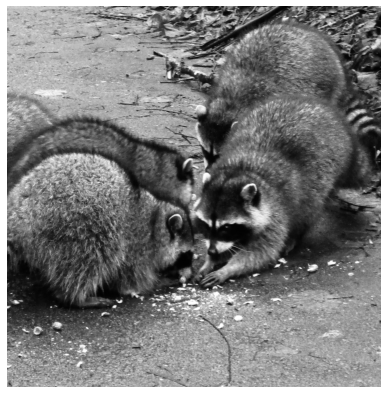

In [17]:
# Let's try another image:
im = Image.open(PATH + "IMG_0028.jpg").convert("LA")
im.save(PATH + "out/greyscale.png")
im = cv2.imread(PATH + "out/greyscale.png")
imshow(im)
axis("off")

(-0.5, 4532.5, 1540.5, -0.5)

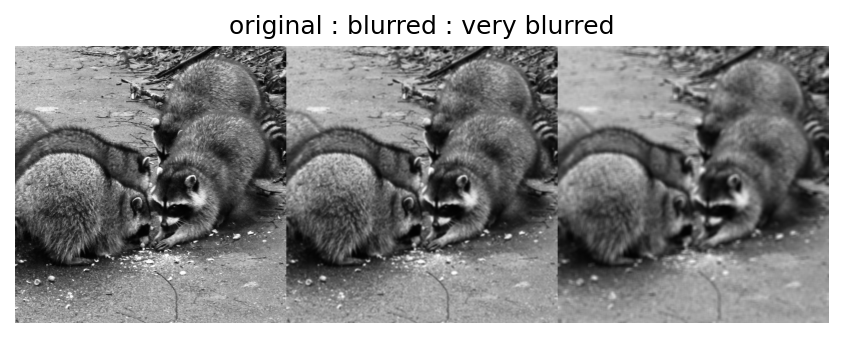

In [18]:
# Blur the image
blur_1 = cv2.blur(im, ksize=(10, 10))  # ksize - blurring kernel size
# the bigger it is, the more blurred image will end up
blur_2 = cv2.blur(im, ksize=(20, 20))
blur_comparison = np.hstack((im, blur_1, blur_2))

figure(dpi=150)
imshow(blur_comparison)
title("original : blurred : very blurred")
axis("off")

# Image sharpening:

Image sharpening with unsharp masking:

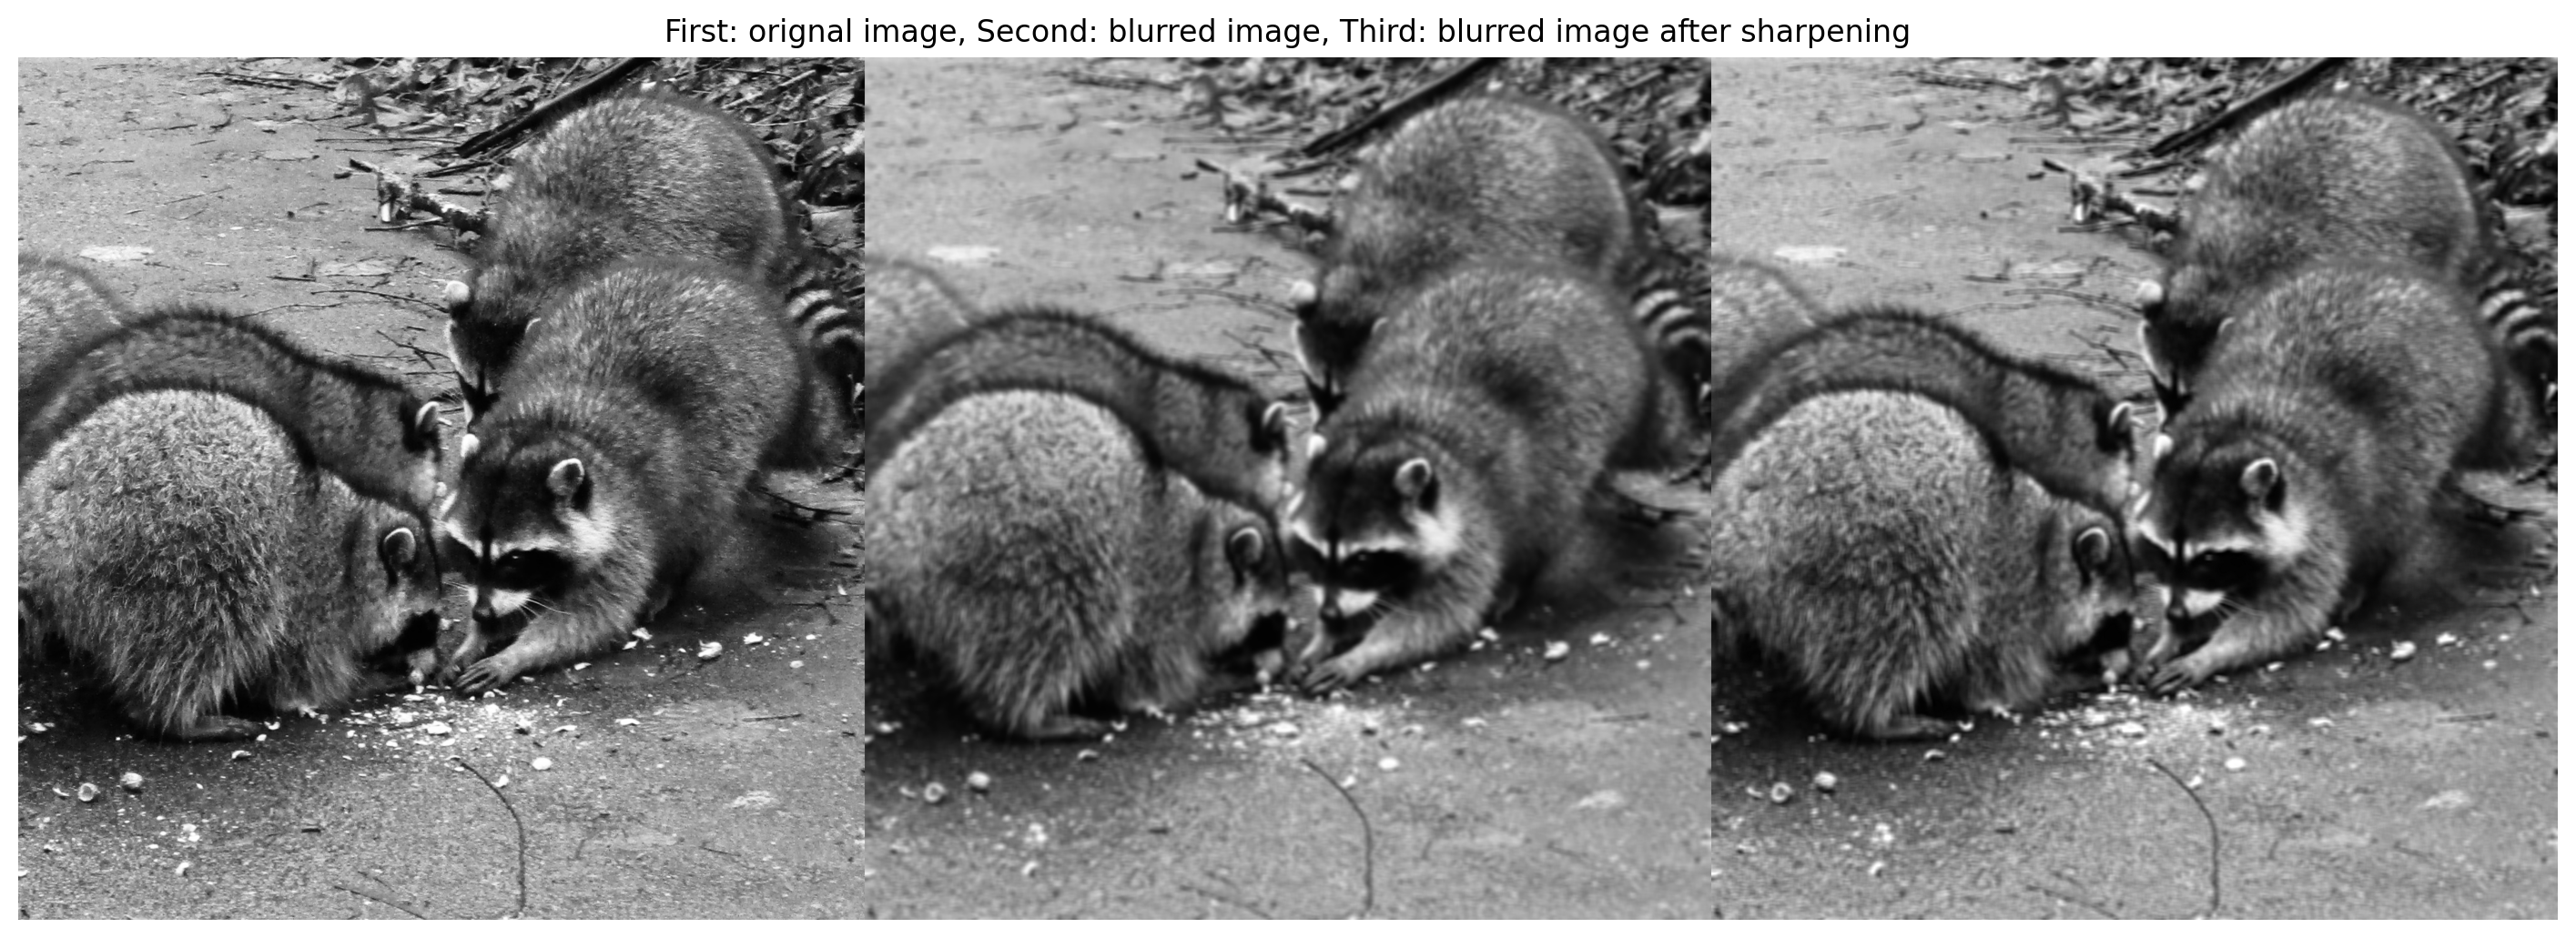

In [19]:
more_blur = cv2.GaussianBlur(blur_1, (15, 15), 0)  # Adjust the tuple values to change
# sharpening intensity
sharpened = cv2.addWeighted(blur_1, 2, more_blur, -1, 0)
unsharp_blur_comparison = np.hstack((im, blur_1, sharpened))

figure(figsize=(18, 7), dpi=200)
imshow(unsharp_blur_comparison)
title(
    "First: orignal image, Second: blurred image, Third: blurred image after sharpening"
)
axis("off")
savefig(PATH + "task_2_unsharp_blur.jpg")

Sharpen the original image:

(-0.5, 3021.5, 1540.5, -0.5)

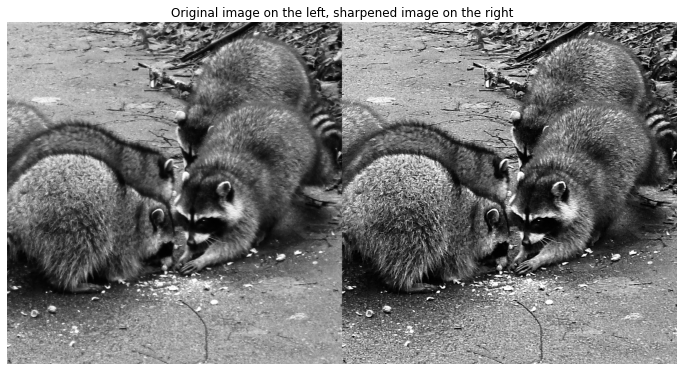

In [20]:
unsharp = cv2.addWeighted(im, 2, blur_1, -1, 0)
unsharp_comparison = np.hstack((im, unsharp))

figure(figsize=(12, 7))
imshow(unsharp_comparison)
title("Original image on the left, sharpened image on the right")
axis("off")

# Laplacian sharpening

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 3021.5, 1540.5, -0.5)

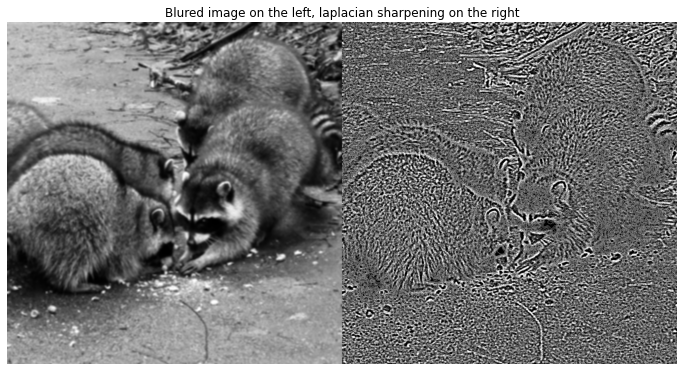

In [21]:
laplacian = cv2.Laplacian(blur_1, cv2.CV_64F)
blur_float = cv2.normalize(
    blur_1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F
)
laplacian_comparison = np.hstack((blur_float, laplacian))

figure(figsize=(12, 7))
imshow(laplacian_comparison)
title("Blured image on the left, laplacian sharpening on the right")
axis("off")